In [2]:
# Logit (with outside) with 1 brand + 2 generics (asymmetric)
# ----------------------------------------------------------
import math

def shares_with_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, V0, alpha):
    """
    Returns (s0, s_b, s_g1, s_g2). Shares sum to 1.
    Utilities:
      u_b  = Vb  - alpha * pb
      u_g1 = Vg1 - alpha * pg1
      u_g2 = Vg2 - alpha * pg2
      u_0  = V0  (outside option utility, a primitive)
    """
    ub  = Vb  - alpha*pb
    ug1 = Vg1 - alpha*pg1
    ug2 = Vg2 - alpha*pg2
    u0  = V0

    eb  = math.exp(ub)
    eg1 = math.exp(ug1)
    eg2 = math.exp(ug2)
    e0  = math.exp(u0)

    Z = e0 + eb + eg1 + eg2
    s0  = e0  / Z
    sb  = eb  / Z
    sg1 = eg1 / Z
    sg2 = eg2 / Z
    return s0, sb, sg1, sg2

def solve_prices_with_outside_asym(Vb, Vg1, Vg2, V0, alpha, MCb, MCg1, MCg2,
                                   p0_b=None, p0_g1=None, p0_g2=None,
                                   damping=0.6, tol=1e-10, max_iter=1000):
    """
    Fixed-point iteration on the single-product logit FOCs (with outside):
        p_i = c_i + 1 / (alpha * (1 - s_i)), for i in {b, g1, g2}.
    Shares are computed via logit with an outside option (V0).

    Returns dict with convergence flag, prices, shares, profits, iterations.
    """
    inv_a = 1.0/alpha
    if p0_b  is None: p0_b  = MCb  + inv_a
    if p0_g1 is None: p0_g1 = MCg1 + inv_a
    if p0_g2 is None: p0_g2 = MCg2 + inv_a

    pb, pg1, pg2 = float(p0_b), float(p0_g1), float(p0_g2)

    for it in range(1, max_iter+1):
        s0, sb, sg1, sg2 = shares_with_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, V0, alpha)

        # FOC right-hand sides
        pb_star  = MCb  + 1.0/(alpha * (1.0 - sb))
        pg1_star = MCg1 + 1.0/(alpha * (1.0 - sg1))
        pg2_star = MCg2 + 1.0/(alpha * (1.0 - sg2))

        # damped updates
        new_pb  = (1.0 - damping)*pb  + damping*pb_star
        new_pg1 = (1.0 - damping)*pg1 + damping*pg1_star
        new_pg2 = (1.0 - damping)*pg2 + damping*pg2_star

        # convergence check
        if max(abs(new_pb - pb), abs(new_pg1 - pg1), abs(new_pg2 - pg2)) < tol:
            pb, pg1, pg2 = new_pb, new_pg1, new_pg2
            s0, sb, sg1, sg2 = shares_with_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, V0, alpha)
            return {
                "converged": True, "iterations": it,
                "pb": pb, "pg1": pg1, "pg2": pg2,
                "s0": s0, "sb": sb, "sg1": sg1, "sg2": sg2,
                "profit_b":  (pb  - MCb)  * sb,
                "profit_g1": (pg1 - MCg1) * sg1,
                "profit_g2": (pg2 - MCg2) * sg2,
                "marg_b": pb - MCb, "marg_g1": pg1 - MCg1, "marg_g2": pg2 - MCg2,
            }

        pb, pg1, pg2 = new_pb, new_pg1, new_pg2

    # not converged
    s0, sb, sg1, sg2 = shares_with_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, V0, alpha)
    return {
        "converged": False, "iterations": max_iter,
        "pb": pb, "pg1": pg1, "pg2": pg2,
        "s0": s0, "sb": sb, "sg1": sg1, "sg2": sg2,
        "profit_b":  (pb  - MCb)  * sb,
        "profit_g1": (pg1 - MCg1) * sg1,
        "profit_g2": (pg2 - MCg2) * sg2,
        "marg_b": pb - MCb, "marg_g1": pg1 - MCg1, "marg_g2": pg2 - MCg2,
    }

# --------------------------
# Example usage / sanity check
# --------------------------
if __name__ == "__main__":
    alpha = 0.0225
    # Example primitives (adjust as needed):
    Vb, Vg1, Vg2 = 3.95, 2.45, 2.45
    V0 = -0.3                   # outside utility; ~10% outside in many similar setups
    MCb, MCg1, MCg2 = 22, 18.5, 18.5

    res = solve_prices_with_outside_asym(Vb, Vg1, Vg2, V0, alpha, MCb, MCg1, MCg2)
    print(res)


{'converged': True, 'iterations': 27, 'pb': 107.62744685670913, 'pg1': 75.54469543692142, 'pg2': 75.54469543692142, 's0': 0.0772767063324708, 'sb': 0.48095562724410224, 'sg1': 0.2208838332117135, 'sg2': 0.2208838332117135, 'profit_b': 41.18300241227957, 'profit_g1': 12.600250992501945, 'profit_g2': 12.600250992501945, 'marg_b': 85.62744685670913, 'marg_g1': 57.044695436921415, 'marg_g2': 57.044695436921415}


In [6]:
# ===============================================================
# Unified NVBP LOGIT model + plot (loser excluded in tranche)
#   - Now includes an OUTSIDE OPTION in all Stage-2 calculations.
#   - Stage 2: Tranche is BP + outside (loser excluded); Residual is BG + outside.
#   - Indifference to get P†; verify A(P†-MC)=Lose(P†).
#   - Plot expected profit vs own bid with a flat lose line from P=Pj.
# ===============================================================

from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Parameters
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand mean utility
    MCb: float     # brand marginal cost
    A: float       # tender capacity (share units out of total 1)
    v0: float      # outside-option utility
    tau: float = 0.5  # tie-break prob if g1=g2 exact tie

@dataclass
class Gen:
    name: str      # "g1" or "g2"
    vg: float      # generic mean utility (also used as Vp for the winner)
    MCg: float     # generic MC

# --------------------------
# Logit (with outside) helpers
# --------------------------
def shares_logit_two_with_outside(p_i: float, p_j: float, Vi: float, Vj: float,
                                  V0: float, alpha: float):
    """
    Two inside goods (i, j) + outside option.
    Returns (s0, s_i, s_j), which sum to 1.
    Utilities:
      u_i = Vi - alpha * p_i
      u_j = Vj - alpha * p_j
      u_0 = V0
    """
    ui = Vi - alpha * p_i
    uj = Vj - alpha * p_j
    u0 = V0

    ei, ej, e0 = np.exp(ui), np.exp(uj), np.exp(u0)
    Z = e0 + ei + ej
    s0 = e0 / Z
    si = ei / Z
    sj = ej / Z
    return s0, si, sj

# --------------------------
# Stage 2: Loser price (residual market only, with outside)
# --------------------------
def loser_best_price(Pb: float, *, Vb: float, Vg: float, MCg: float,
                     alpha: float, s_first: float, V0: float,
                     bounds: Tuple[float,float]=(0.0, 400.0)) -> Tuple[float, Dict]:
    """
    Given Pb and first-market scale s_first (residual = 1 - s_first),
    choose Pg to maximize residual-only profit:
        (Pg - MCg) * (1 - s_first) * S_g^{BG+outside}(Pb, Pg).
    FOC (single-product logit) still: Pg = MCg + 1 / [ alpha * (1 - S_g) ].
    Here, S_g is the overall g-share including the outside option.
    """
    residual = max(0.0, 1.0 - s_first)
    if residual <= 1e-12:
        return max(0.0, MCg), {"residual": residual, "note": "no_residual"}

    Pg = float(np.clip(MCg + 1.0/alpha, bounds[0], bounds[1]))
    damping, tol, maxit = 0.6, 1e-10, 500

    for it in range(maxit):
        _, Sb_BG, Sg_BG = shares_logit_two_with_outside(Pb, Pg, Vb, Vg, V0, alpha)
        Pg_star = MCg + 1.0 / (alpha * (1.0 - Sg_BG))
        new = (1.0 - damping) * Pg + damping * Pg_star
        new = float(np.clip(new, bounds[0], bounds[1]))
        if abs(new - Pg) < tol:
            Pg = new
            _, Sb_BG, Sg_BG = shares_logit_two_with_outside(Pb, Pg, Vb, Vg, V0, alpha)
            prof = (Pg - MCg) * residual * Sg_BG
            return Pg, {"iterations": it+1, "Sg_BG": Sg_BG, "Sb_BG": Sb_BG,
                        "residual": residual, "profit": prof}
        Pg = new

    _, Sb_BG, Sg_BG = shares_logit_two_with_outside(Pb, Pg, Vb, Vg, V0, alpha)
    prof = (Pg - MCg) * residual * Sg_BG
    return Pg, {"iterations": maxit, "Sg_BG": Sg_BG, "Sb_BG": Sb_BG,
                "residual": residual, "profit": prof, "warn": "loser_fp_not_converged"}

# --------------------------
# Stage 2: Brand price (first + residual, both with outside)
# --------------------------
def brand_total_profit(Pb: float, Pp: float, *,
                       Vb: float, Vp: float, Vg: float,
                       MCb: float, MCg: float, A: float, alpha: float, V0: float,
                       loser_bounds: Tuple[float,float]=(0.0,400.0)) -> Tuple[float, Dict]:
    """
    For a given Pb and tender price Pp (winner fixed), compute:
      - First-market shares (BP + outside), s = min(1, A / Sp_BP)
      - Loser best response Pg*(Pb) on residual (BG + outside)
      - Total brand profit:
            (Pb - MCb) * [ s * Sb_BP + (1-s) * Sb_BG(Pb,Pg*) ]
    """
    # First market: B vs P (loser excluded) + outside
    _, Sb_BP, Sp_BP = shares_logit_two_with_outside(Pb, Pp, Vb, Vp, V0, alpha)
    if Sp_BP <= 1e-12:
        s_first = 1.0
    else:
        s_first = min(1.0, A / Sp_BP)

    # Residual: B vs loser + outside; loser picks Pg*
    Pg, Linfo = loser_best_price(Pb, Vb=Vb, Vg=Vg, MCg=MCg,
                                 alpha=alpha, s_first=s_first, V0=V0,
                                 bounds=loser_bounds)
    _, Sb_BG, Sg_BG = shares_logit_two_with_outside(Pb, Pg, Vb, Vg, V0, alpha)

    qb_total = s_first * Sb_BP + (1.0 - s_first) * Sb_BG
    profit_b = max(0.0, Pb - MCb) * qb_total

    return profit_b, dict(
        s_first=s_first, residual=1.0 - s_first,
        Sb_BP=Sb_BP, Sp_BP=Sp_BP,
        Pg_opt=Pg, Sb_BG=Sb_BG, Sg_BG=Sg_BG,
        qb_total=qb_total, loser_info=Linfo
    )

def brand_best_price(Pp: float, *, Vb: float, Vp: float, Vg: float,
                     MCb: float, MCg: float, A: float, alpha: float, V0: float,
                     bounds: Tuple[float,float]=(0.0,400.0)) -> Tuple[float, Dict]:
    """
    Coarse-to-fine grid search for Pb maximizing brand_total_profit (with outside).
    """
    lo, hi = bounds
    best_val, best_pb, best_details = -1e300, None, None
    for N in (401, 201, 101, 61, 31):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            v, d = brand_total_profit(pb, Pp, Vb=Vb, Vp=Vp, Vg=Vg,
                                      MCb=MCb, MCg=MCg, A=A, alpha=alpha, V0=V0)
            vals.append(v)
            if v > best_val:
                best_val, best_pb, best_details = v, pb, d
        idx = int(np.argmax(vals))
        lo = max(bounds[0], grid[max(0, idx-5)])
        hi = min(bounds[1], grid[min(N-1, idx+5)])
    return float(best_pb), dict(best_profit=best_val, details=best_details, bracket=(lo,hi))

# --------------------------
# Stage 2 wrapper at given Pp (winner/loser known)
# --------------------------
def stage2_outcomes_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen,
                                 pb_bounds: Tuple[float,float]=(0.0,400.0),
                                 pg_bounds: Tuple[float,float]=(0.0,400.0)) -> Dict:
    """
    Compute Pb* and Pg* with BP-only tranche (loser excluded) and BG residual,
    both with an outside option present.
    """
    Pb, info_b = brand_best_price(Pp,
                                  Vb=common.vb, Vp=winner.vg, Vg=loser.vg,
                                  MCb=common.MCb, MCg=loser.MCg, A=common.A,
                                  alpha=common.alpha, V0=common.v0,
                                  bounds=pb_bounds)
    d = info_b["details"]

    Pg = d["Pg_opt"]
    s_first = d["s_first"]; residual = d["residual"]
    Sb_BP, Sp_BP = d["Sb_BP"], d["Sp_BP"]
    Sb_BG, Sg_BG = d["Sb_BG"], d["Sg_BG"]

    qb_first = s_first * Sb_BP
    qp_first = s_first * Sp_BP
    qb_res   = residual * Sb_BG
    qg_res   = residual * Sg_BG

    qb_total = qb_first + qb_res
    qp_total = qp_first
    qg_total = qg_res

    profit_brand = max(0.0, Pb - common.MCb) * qb_total
    profit_loser = max(0.0, Pg - loser.MCg) * qg_total
    profit_win_tranche = common.A * (Pp - winner.MCg)

    binds = (s_first < 1.0 - 1e-12)

    return dict(
        Pb=Pb, Pg=Pg, Pp=Pp,
        qb_first=qb_first, qp_first=qp_first, qg_first=0.0,   # loser excluded in first market
        qb_total=qb_total, qp_total=qp_total, qg_total=qg_total,
        residual_mass=residual, binds=binds,
        profit_brand_retail=profit_brand,
        profit_loser=profit_loser,
        profit_winner_tranche=profit_win_tranche,
        solver_info=info_b
    )

# --------------------------
# Bidding stage (Δ = Win - Lose), robust root-pick
# --------------------------
def expected_profit_generic_i(Pi: float, Pj: float, *, i: Gen, j: Gen, common: Common,
                              pb_bounds=(0.0,400.0)) -> float:
    if Pi < Pj:
        return common.A * max(0.0, Pi - i.MCg)
    elif Pi > Pj:
        out = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i, pb_bounds=pb_bounds)
        return out["profit_loser"]
    else:
        win_prob = common.tau if i.name == "g1" else (1.0 - common.tau)
        tranche = common.A * max(0.0, Pi - i.MCg)
        out_lose = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i, pb_bounds=pb_bounds)["profit_loser"]
        return win_prob * tranche + (1.0 - win_prob) * out_lose

def indifference_prices(i: Gen, j: Gen, common: Common,
                        bounds=(0.0, 200.0), gridN: int = 1201,
                        pb_bounds=(0.0,400.0)) -> Tuple[Optional[float], str, Dict]:
    """
    Find P in [bounds] s.t. Δ(P)=Win-Lose=0 for i vs j.
    Guard logic unchanged; uses Stage-2 with outside under the hood.
    """
    def delta(P):
        win  = common.A * max(0.0, P - i.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=j, loser=i, pb_bounds=pb_bounds)["profit_loser"]
        return win - lose

    lo, hi = bounds
    xs = np.linspace(lo, hi, gridN)
    fs = np.array([delta(x) for x in xs])

    if np.all(fs > 0):
        return max(0.0, i.MCg), "all_positive_pick_MC", {"grid": xs, "vals": fs}
    if np.all(fs < 0):
        return hi, "all_negative_pick_upper", {"grid": xs, "vals": fs}

    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) <= 0)[0]
    roots: List[float] = []
    for k in idx:
        a, b = xs[k], xs[k+1]
        fa, fb = fs[k], fs[k+1]
        for _ in range(80):
            m = 0.5*(a+b)
            fm = delta(m)
            if abs(fm) < 1e-10 or (b-a) < 1e-10:
                roots.append(m); break
            if fa*fm <= 0: b, fb = m, fm
            else:          a, fa = m, fm
        else:
            roots.append(0.5*(a+b))
    if len(roots) == 0:
        return None, "no_root_on_interval", {"grid": xs, "vals": fs}

    P_pick = max(roots)  # pick larger root if multiple
    return P_pick, "ok", {"roots": roots}
    
def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen,
                                bid_bounds=(0.0,200.0), pb_bounds=(0.0,400.0),
                                tol_equal: float = 1e-6) -> Dict:
    P1_dag, s1, _ = indifference_prices(g1, g2, common, bounds=bid_bounds, pb_bounds=pb_bounds)
    P2_dag, s2, _ = indifference_prices(g2, g1, common, bounds=bid_bounds, pb_bounds=pb_bounds)

    out = {"P1_dagger": P1_dag, "P2_dagger": P2_dag, "status_g1": s1, "status_g2": s2}

    def pack(mode, Pp, w, l, reason):
        st2 = stage2_outcomes_given_winner(Pp, common=common, winner=w, loser=l, pb_bounds=pb_bounds)
        out.update({
            "mode": mode, "Pp_star": Pp, "winner": w.name, "loser": l.name, "reason": reason,
            "Pb_star": st2["Pb"], "Pg_star": st2["Pg"],
            "qb_first": st2["qb_first"], "qp_first": st2["qp_first"], "qg_first": 0.0,
            "qb_total": st2["qb_total"], "qp_total": st2["qp_total"], "qg_total": st2["qg_total"],
            "residual_mass": st2["residual_mass"], "binds": st2["binds"],
            "profit_winner_tranche": st2["profit_winner_tranche"],
            "profit_loser_retail": st2["profit_loser"],
            "profit_brand_retail": st2["profit_brand_retail"],
            "solver_info": st2["solver_info"],
        })
        return out

    if (P1_dag is not None) and (P2_dag is not None) and s1 == "ok" and s2 == "ok":
        if abs(P1_dag - P2_dag) <= tol_equal:
            return pack("indifference", 0.5*(P1_dag+P2_dag), g1, g2,
                        f"Equal daggers (|Δ|≤{tol_equal}).")
        else:
            Pp = max(P1_dag, P2_dag)
            return pack("indifference", Pp,
                        (g1 if P1_dag < P2_dag else g2),
                        (g2 if P1_dag < P2_dag else g1),
                        "Different daggers: Pp=max{P1†,P2†}; lower-† firm wins.")

    picks = []
    for P_dag, status, who in [(P1_dag, s1, g1), (P2_dag, s2, g2)]:
        if status in ("all_positive_pick_MC", "all_negative_pick_upper", "ok"):
            if P_dag is not None:
                picks.append((P_dag, who))
    if len(picks) >= 1:
        Pp, w = min(picks, key=lambda x: x[0])  # lower bidder wins
        l = g2 if w is g1 else g1
        return pack("guard_or_partial", Pp, w, l, f"Guard/partial result (status: {s1}, {s2}).")

    Pp = 0.5*(bid_bounds[0]+bid_bounds[1])
    return pack("fallback_mid", Pp, g1, g2, "No clean roots; fallback mid.")

# --------------------------
# One-shot stage-2 at rival bid (for flat lose line)
# --------------------------
def stage2_once_at_rival_bid(
    Pj_fixed: float, *, me: Gen, rival: Gen, common: Common,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)
):
    """
    Evaluate tranche/residual once at Pp = Pj_fixed (rival wins), with outside option.
    """
    st2 = stage2_outcomes_given_winner(
        Pp=Pj_fixed, common=common, winner=rival, loser=me,
        pb_bounds=pb_bounds, pg_bounds=pg_bounds
    )
    return {
        "Pb_star": float(st2["Pb"]),
        "Pg_star": float(st2["Pg"]),
        "profit_loser": float(st2["profit_loser"]),
        "profit_brand": float(st2["profit_brand_retail"]),
        "stage2_full": st2
    }

# --------------------------
# Plot expected profit vs own bid (flat lose line from P=Pj)
# --------------------------
def plot_expected_profit_vs_own_bid(
    common: Common, g1: Gen, g2: Gen, *,
    me_name: str,
    Pj_fixed: float,
    Pi_min: float = 0.0, Pi_max: float = 100.0, Pi_points: int = 401,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
    bid_upper_for_BR: float = 100.0,
    show_share_bar: bool = True
):
    me    = g1 if me_name == "g1" else g2
    rival = g2 if me_name == "g1" else g1

    # Run stage-2 once at rival’s bid
    st2_once = stage2_once_at_rival_bid(
        Pj_fixed, me=me, rival=rival, common=common,
        pb_bounds=(max(common.MCb, pb_bounds[0]), pb_bounds[1]),
        pg_bounds=(max(me.MCg, pg_bounds[0]), pg_bounds[1])
    )
    lose_prof = st2_once["profit_loser"]

    eps = 1e-8
    base_grid = np.linspace(Pi_min, Pi_max, Pi_points)
    Pi_grid = np.unique(np.r_[base_grid, Pj_fixed, max(Pi_min, Pj_fixed - eps)])

    tranche_line = common.A * np.maximum(Pi_grid - me.MCg, 0.0)
    lose_line    = np.where(Pi_grid >= Pj_fixed, lose_prof, np.nan)
    Evec = np.where(Pi_grid < Pj_fixed, tranche_line, lose_prof)

    # Analytic argmax
    win_payoff_at_Pj = common.A * max(Pj_fixed - me.MCg, 0.0)
    if win_payoff_at_Pj > lose_prof:
        Pi_star  = min(max(Pj_fixed - eps, Pi_min), bid_upper_for_BR)
        prof_star = common.A * (Pi_star - me.MCg)
        side = "win"
    else:
        Pi_star  = max(Pj_fixed, me.MCg)
        prof_star = lose_prof
        side = "lose"

    # --- Plot expected profit curve ---
    plt.figure(figsize=(7.5, 4.5))
    plt.plot(Pi_grid, Evec, label=f"Expected profit (given Pj={Pj_fixed:.3f})")
    plt.plot(Pi_grid, np.where(Pi_grid < Pj_fixed, tranche_line, np.nan),
             linestyle="--", label="Win tranche  A*(Pi − MCi)")
    plt.plot(Pi_grid, lose_line, linestyle="--", label="Lose retail profit (flat ≥Pj)")
    plt.axvline(Pj_fixed, linestyle=":", color="k", label=f"Pj={Pj_fixed:.3f}")
    plt.scatter([Pi_star], [prof_star], color="red", zorder=5,
                label=f"Analytic argmax → {side}, Pi*≈{Pi_star:.3f}")
    plt.xlabel("Own bid Pi")
    plt.ylabel("Expected profit")
    plt.title(f"Generic {me.name}: Expected profit vs own bid (LOGIT + outside)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Retrieve & print detailed shares ---
    # --- Detailed shares using endogenous s_first ---
    st2_full = st2_once["stage2_full"]
    Pb = st2_full["Pb"]; Pg = st2_full["Pg"]; Pp = Pj_fixed
    s_first = st2_full["solver_info"]["details"]["s_first"]  # comes from brand_total_profit

    # BP (brand vs winner + outside)
    s0_BP, Sb_BP, Sp_BP = shares_logit_two_with_outside(Pb, Pp, common.vb, (g1 if me_name=="g2" else g2).vg,
                                                    common.v0, common.alpha)
    # BG (brand vs loser + outside)
    s0_BG, Sb_BG, Sg_BG = shares_logit_two_with_outside(Pb, Pg, common.vb, me.vg,
                                                    common.v0, common.alpha)

    # Aggregate with s_first (endogenous)
    s0_total = s_first * s0_BP + (1 - s_first) * s0_BG
    Sb_total = s_first * Sb_BP + (1 - s_first) * Sb_BG
    Sp_total = s_first * Sp_BP          # = A if s_first = A / Sp_BP < 1
    Sg_total = (1 - s_first) * Sg_BG

    # sanity
    ssum = s0_total + Sb_total + Sp_total + Sg_total

    print("\n=== Stage-2 Share Breakdown (with outside option) ===")
    print(f"Outside share (s0):   {s0_total:.4f}")
    print(f"Brand share (Sb):     {Sb_total:.4f}")
    print(f"Winner share (Sp):    {Sp_total:.4f}")
    print(f"Loser share (Sg):     {Sg_total:.4f}")
    print(f"s_first (endog):      {s_first:.4f}   (A={common.A:.4f}, Sp_BP={Sp_BP:.4f})")
    print(f"Sum check:            {ssum:.4f}")
    print("=====================================================\n")

    # in the function's return dict:
    return {
        "Pi_grid": Pi_grid,
        "Evec": Evec,
        "Pi_star": Pi_star,
        "profit_star": prof_star,
        "shares": {
            "s0_total": s0_total, "Sb_total": Sb_total, "Sp_total": Sp_total, "Sg_total": Sg_total,
            "s0_BP": s0_BP, "Sb_BP": Sb_BP, "Sp_BP": Sp_BP,
            "s0_BG": s0_BG, "Sb_BG": Sb_BG, "Sg_BG": Sg_BG,
            "s_first": s_first, "A": common.A
        },
        "stage2_once": st2_once
    }



 NVBP equilibrium with outside option
---------------------------------------------------------------
 Mode: indifference
 Winner: g1  Loser: g2
 Reason: Equal daggers (|Δ|≤1e-06).
 Pp* (procurement price): 26.8780
 Pb* (brand retail price): 126.2319
 Pg* (loser retail price): 83.6987
---------------------------------------------------------------
 Brand profit (retail): 36.5047
 Loser profit (retail): 4.1890
 Winner profit (tender): 4.1890
 Residual mass: 0.2018
 Binds: True


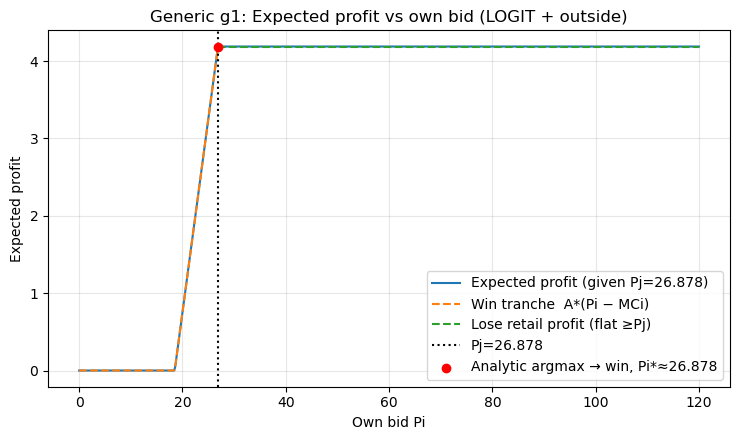


=== Stage-2 Share Breakdown (with outside option) ===
Outside share (s0):   0.0855
Brand share (Sb):     0.3502
Winner share (Sp):    0.5000
Loser share (Sg):     0.0642
s_first (endog):      0.7982   (A=0.5000, Sp_BP=0.6264)
Sum check:            1.0000



In [7]:
# ===============================================================
# FUNNEL / RUNNER for NVBP model with OUTSIDE OPTION
# ===============================================================

if __name__ == "__main__":
    # --------------------------
    # 1. Parameters (tuned for realism)
    # --------------------------
    # Desired: Pb ≈ 108, Pg ≈ 76, outside share ≈ 7.7%
    alpha = 0.0225
    Vb, Vg1, Vg2 = 3.95, 2.45, 2.45
    v0  = -0.3
    A   = 0.5
    MCb = 22.0
    MCg1 = 18.5
    MCg2 = 18.5              # generic MC = 25% of 77

    # --------------------------
    # 2. Instantiate primitives
    # --------------------------
    common = Common(alpha=alpha, vb=Vb, MCb=MCb, A=A, v0=v0)
    g1 = Gen(name="g1", vg=Vg1, MCg=MCg1)
    g2 = Gen(name="g2", vg=Vg2, MCg=MCg2)

    # --------------------------
    # 3. Compute equilibrium by indifference
    # --------------------------
    eq = equilibrium_by_indifference(common, g1, g2)

    print("===============================================================")
    print(" NVBP equilibrium with outside option")
    print("---------------------------------------------------------------")
    print(f" Mode: {eq['mode']}")
    print(f" Winner: {eq['winner']}  Loser: {eq['loser']}")
    print(f" Reason: {eq['reason']}")
    print(f" Pp* (procurement price): {eq['Pp_star']:.4f}")
    print(f" Pb* (brand retail price): {eq['Pb_star']:.4f}")
    print(f" Pg* (loser retail price): {eq['Pg_star']:.4f}")
    print("---------------------------------------------------------------")
    print(f" Brand profit (retail): {eq['profit_brand_retail']:.4f}")
    print(f" Loser profit (retail): {eq['profit_loser_retail']:.4f}")
    print(f" Winner profit (tender): {eq['profit_winner_tranche']:.4f}")
    print(f" Residual mass: {eq['residual_mass']:.4f}")
    print(f" Binds: {eq['binds']}")
    print("===============================================================")

    # --------------------------
    # 4. Plot expected profit vs own bid
    # --------------------------
    # Use the equilibrium Pp* as rival bid, plot for g1
    plot_expected_profit_vs_own_bid(
        common, g1, g2,
        me_name="g1",
        Pj_fixed=eq["Pp_star"],
        Pi_min=0.0, Pi_max=120.0,
        Pi_points=601
    )


In [17]:
# ===============================================================
# NVBP LOGIT (Two-Market) with A-guaranteed tranche + Jump-aware search
# ===============================================================

from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Parameters
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand utility level
    MCb: float     # brand marginal cost
    A: float       # tranche capacity (share units out of total 1)
    v0: float      # outside-option utility
    tau: float = 0.5  # tie-break prob if g1=g2 exact tie

@dataclass
class Gen:
    name: str
    vg: float      # generic (also winner) mean utility
    MCg: float     # generic MC


# --------------------------
# Logit helpers
# --------------------------
def shares_0BPG(pb: float, pp: float, pg: float,
                Vb: float, Vp: float, Vg: float, V0: float,
                alpha: float) -> Tuple[float,float,float,float]:
    """Latent MNL shares over {0,B,P,G}."""
    uB = Vb - alpha*pb
    uP = Vp - alpha*pp
    uG = Vg - alpha*pg
    u0 = V0
    eB, eP, eG, e0 = np.exp(uB), np.exp(uP), np.exp(uG), np.exp(u0)
    Z = e0 + eB + eP + eG
    return e0/Z, eB/Z, eP/Z, eG/Z  # s0,sB,sP,sG

def shares_0BG(pb: float, pg: float,
               Vb: float, Vg: float, V0: float,
               alpha: float) -> Tuple[float,float,float]:
    """Latent MNL shares over {0,B,G} (P removed)."""
    uB = Vb - alpha*pb
    uG = Vg - alpha*pg
    u0 = V0
    eB, eG, e0 = np.exp(uB), np.exp(uG), np.exp(u0)
    Z = e0 + eB + eG
    return e0/Z, eB/Z, eG/Z  # s0,sB,sG


# --------------------------
# Two-market allocation with tranche cap A (A is guaranteed to winner)
# --------------------------
def twomarket_allocation(pb: float, pg: float, Pp: float, *,
                         Vb: float, Vp: float, Vg: float, V0: float,
                         alpha: float, A: float) -> Dict:
    """
    1) Latent {0,B,P,G}: s0,sB,sP,sG
    2) First-market size s = min(1, A/sP)  (s=1 if sP=0)
       First-market quantities: s * (s0,sB,sP,sG)   [if s<1 then s*sP=A binds]
    3) Residual (1-s) over {0,B,G}: r0,rB,rG
    4) Totals: q0,qB,qP,qG.  (Winner only sells in first market.)
    """
    s0, sB, sP, sG = shares_0BPG(pb, Pp, pg, Vb, Vp, Vg, V0, alpha)

    if sP <= 1e-14:
        s = 1.0
    else:
        s = min(1.0, A / sP)

    # First market
    q0_f, qB_f, qP_f, qG_f = s*s0, s*sB, s*sP, s*sG

    # Residual
    r0, rB, rG = shares_0BG(pb, pg, Vb, Vg, V0, alpha)
    q0_r, qB_r, qG_r = (1.0 - s)*r0, (1.0 - s)*rB, (1.0 - s)*rG

    # Totals
    q0 = q0_f + q0_r
    qB = qB_f + qB_r
    qP = qP_f                    # winner sells only in tranche market
    qG = qG_f + qG_r

    binds = (s < 0.999999)
    residual_mass = 1.0 - s

    return dict(
        latent=dict(s0=s0, sB=sB, sP=sP, sG=sG),
        s_first=s, residual_mass=residual_mass, binds=binds,
        q=dict(q0=q0, qB=qB, qP=qP, qG=qG)
    )


# --------------------------
# Stage-2 evaluation & BRs
# --------------------------
def stage2_eval(pb: float, pg: float, Pp: float, *,
                Vb: float, Vp: float, Vg: float, V0: float,
                MCb: float, MCg_loser: float, MCg_winner: float,
                alpha: float, A: float) -> Dict:
    alloc = twomarket_allocation(pb, pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0, alpha=alpha, A=A)
    q = alloc["q"]
    # Retail profits (brand & loser)
    prof_b = max(0.0, pb - MCb) * q["qB"]
    prof_l = max(0.0, pg - MCg_loser) * q["qG"]
    # Winner tranche profit: A is guaranteed
    prof_w = A * max(0.0, Pp - MCg_winner)
    return dict(**alloc, profit_brand=prof_b, profit_loser=prof_l, profit_winner_tranche=prof_w)

def best_response_brand(pg_fixed: float, Pp: float, *,
                        Vb: float, Vp: float, Vg: float, V0: float,
                        MCb: float, MCg_loser: float, MCg_winner: float,
                        alpha: float, A: float, pb_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pb_bounds
    best_v, best_pb, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            st = stage2_eval(pb, pg_fixed, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                             MCb=MCb, MCg_loser=MCg_loser, MCg_winner=MCg_winner,
                             alpha=alpha, A=A)
            v = st["profit_brand"]
            vals.append(v)
            if v > best_v:
                best_v, best_pb, best_eval = v, pb, st
        idx = int(np.argmax(vals))
        lo = max(pb_bounds[0], grid[max(0, idx-4)])
        hi = min(pb_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pb), dict(best_profit=best_v, eval=best_eval)

def best_response_loser(pb_fixed: float, Pp: float, *,
                        Vb: float, Vp: float, Vg: float, V0: float,
                        MCb: float, MCg_loser: float, MCg_winner: float,
                        alpha: float, A: float, pg_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    lo, hi = pg_bounds
    best_v, best_pg, best_eval = -1e300, None, None
    for N in (301, 161, 81, 41, 21):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pg in grid:
            st = stage2_eval(pb_fixed, pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                             MCb=MCb, MCg_loser=MCg_loser, MCg_winner=MCg_winner,
                             alpha=alpha, A=A)
            v = st["profit_loser"]
            vals.append(v)
            if v > best_v:
                best_v, best_pg, best_eval = v, pg, st
        idx = int(np.argmax(vals))
        lo = max(pg_bounds[0], grid[max(0, idx-4)])
        hi = min(pg_bounds[1], grid[min(N-1, idx+4)])
    return float(best_pg), dict(best_profit=best_v, eval=best_eval)

def solve_stage2(Pp: float, *,
                 Vb: float, Vp: float, Vg: float, V0: float,
                 MCb: float, MCg_winner: float, MCg_loser: float,
                 alpha: float, A: float,
                 pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
                 max_iter=60, tol=1e-6, damping=0.6) -> Dict:

    inv_a = 1.0/max(alpha, 1e-9)
    pb = max(pb_bounds[0], MCb + inv_a)
    pg = max(pg_bounds[0], MCg_loser + inv_a)

    seq = []
    for it in range(1, max_iter+1):
        pb_br, info_b = best_response_brand(pg, Pp,
                                            Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                                            MCb=MCb, MCg_loser=MCg_loser, MCg_winner=MCg_winner,
                                            alpha=alpha, A=A,
                                            pb_bounds=pb_bounds)
        pb = (1.0 - damping)*pb + damping*pb_br

        pg_br, info_g = best_response_loser(pb, Pp,
                                            Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                                            MCb=MCb, MCg_loser=MCg_loser, MCg_winner=MCg_winner,
                                            alpha=alpha, A=A,
                                            pg_bounds=pg_bounds)
        pg = (1.0 - damping)*pg + damping*pg_br

        seq.append((pb, pg, info_b["best_profit"], info_g["best_profit"]))
        if max(abs(pb - pb_br), abs(pg - pg_br)) < tol:
            break

    st = stage2_eval(pb, pg, Pp, Vb=Vb, Vp=Vp, Vg=Vg, V0=V0,
                     MCb=MCb, MCg_loser=MCg_loser, MCg_winner=MCg_winner,
                     alpha=alpha, A=A)

    return dict(
        converged=(it < max_iter),
        iterations=it,
        pb=pb, pg=pg, Pp=Pp,
        **st,  # includes quantities, latent, binds, residual_mass, profits
        sequence=seq
    )

def stage2_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen,
                        pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)) -> Dict:
    sol = solve_stage2(Pp,
                       Vb=common.vb, Vp=winner.vg, Vg=loser.vg, V0=common.v0,
                       MCb=common.MCb, MCg_winner=winner.MCg, MCg_loser=loser.MCg,
                       alpha=common.alpha, A=common.A,
                       pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    q = sol["q"]; s = sol["latent"]
    return dict(
        Pb=sol["pb"], Pg=sol["pg"], Pp=Pp,
        qb_total=q["qB"], qp_total=q["qP"], qg_total=q["qG"],
        residual_mass=sol["residual_mass"], binds=sol["binds"],
        profit_brand_retail=sol["profit_brand"],
        profit_loser=sol["profit_loser"],
        profit_winner_tranche=sol["profit_winner_tranche"],
        latent_shares=s,
        solver_info=sol
    )


# --------------------------
# Jump-aware monotone search for the dagger
# --------------------------
def indifference_price_monotone(i: Gen, j: Gen, common: Common, *,
                                upper=100.0, init=30.0, step=5.0,
                                pb_bounds=(0.0,200.0), pg_bounds=(0.0,200.0),
                                tol=1e-6, max_bisect=80):
    """
    Monotone search with discontinuity detection.
    - If Δ(init)>0: step DOWN toward MC; if bracket, bisection; else return 'mc'.
    - If Δ(init)<0: step UP toward upper; if bracket, bisection; else return 'upper'.
    - If 'binds' flips between steps → return 'jump' with one-sided limits.
    Returns: (tag, P_star, info) with tag in {"root","mc","upper","jump"}.
    """
    def eval_lose(P):
        st = stage2_given_winner(P, common=common, winner=j, loser=i,
                                 pb_bounds=pb_bounds, pg_bounds=pg_bounds)
        return st["profit_loser"], st  # lose-profit, full dict

    def eval_delta(P):
        lose, st = eval_lose(P)
        win = common.A * max(P - i.MCg, 0.0)
        return win - lose, win, lose, st

    def bisection(a, fa, b, fb):
        # assumes zero is bracketed in [a,b]
        for _ in range(max_bisect):
            m = 0.5*(a+b)
            fm, wm, lm, stm = eval_delta(m)
            if abs(fm) <= tol or (b-a) < tol:
                ok, diag = _accept_root(m, common, i, j, pb_bounds, pg_bounds, tol_check=1e-7)
                if ok:
                   return ("root", m, {"win_at_P": diag["g1" if i.name=="g1" else "g2"]["win"],
                            "lose_at_P": diag["g1" if i.name=="g1" else "g2"]["lose"],
                            "delta":     0.0,
                            "stage2_lose": stage2_given_winner(m, common=common, winner=j, loser=i,
                                                               pb_bounds=pb_bounds, pg_bounds=pg_bounds)})
                # fail strict check → treat as a discontinuity
                return ("jump", m, {"note": "interval small but |Δ| not small; likely binding flip"})
            if fa*fm <= 0:
                b, fb = m, fm
            else:
                a, fa = m, fm
        fm, wm, lm, stm = eval_delta(0.5*(a+b))
        return ("root", 0.5*(a+b), {"win_at_P": wm, "lose_at_P": lm, "delta": fm, "stage2_lose": stm})

    MC  = i.MCg
    eps = 1e-9
    P0  = max(MC + eps, init)
    d0, w0, l0, st0 = eval_delta(P0)

    # direction: -1 (down toward MC) if Δ>0; +1 (up to upper) if Δ<0; 0 if exact root
    direction = -1 if d0 > 0.0 else (+1 if d0 < 0.0 else 0)
    if direction == 0:
        return ("root", P0, {"win_at_P": w0, "lose_at_P": l0, "delta": d0, "stage2_lose": st0})

    def next_P(P):
        return (max(MC+eps, P - step) if direction<0 else min(upper, P + step))

    binds_prev = st0["solver_info"]["binds"]
    P_prev, d_prev, w_prev, l_prev, st_prev = P0, d0, w0, l0, st0

    while True:
        P_cur = next_P(P_prev)
        # guard if we hit boundary without a bracket/jump
        if (direction<0 and P_cur <= MC+eps) or (direction>0 and P_cur >= upper-eps):
            tag = "mc" if direction<0 else "upper"
            P_star = MC if direction<0 else upper
            d,w,l,st = eval_delta(P_star)
            return (tag, P_star,
                    {"win_at_P": w, "lose_at_P": l, "delta": d, "stage2_lose": st})

        d_cur, w_cur, l_cur, st_cur = eval_delta(P_cur)

        # Continuous bracket (root between P_prev and P_cur)
        if (d_prev < 0.0 <= d_cur) or (d_prev > 0.0 >= d_cur) or (abs(d_cur) <= tol):
            a, fa = (P_prev, d_prev)
            b, fb = (P_cur, d_cur)
            if a > b: a, b, fa, fb = b, a, fb, fa
            return bisection(a, fa, b, fb)

        # Discontinuity detected (binds flip)
        binds_cur = st_cur["solver_info"]["binds"]
        if binds_cur != binds_prev:
            # Return one-sided limits around the jump
            if P_prev < P_cur:
                P_left, P_right = P_prev, P_cur
                d_left, d_right = d_prev, d_cur
                w_left, l_left  = w_prev, l_prev
                w_right, l_right= w_cur,  l_cur
                st_left, st_right = st_prev, st_cur
            else:
                P_left, P_right = P_cur, P_prev
                d_left, d_right = d_cur, d_prev
                w_left, l_left  = w_cur,  l_cur
                w_right, l_right= w_prev, l_prev
                st_left, st_right = st_cur, st_prev

            return ("jump", P_right, {
                "P_left": P_left, "P_right": P_right,
                "win_left":  w_left,  "lose_left":  l_left,  "delta_left":  d_left,
                "win_right": w_right, "lose_right": l_right, "delta_right": d_right,
                "stage2_left":  st_left,
                "stage2_right": st_right
            })

        # advance
        P_prev, d_prev, w_prev, l_prev, st_prev = P_cur, d_cur, w_cur, l_cur, st_cur

def _delta_at(i: Gen, j: Gen, common: Common, P: float,
              pb_bounds, pg_bounds):
    lose = stage2_given_winner(P, common=common, winner=j, loser=i,
                               pb_bounds=pb_bounds, pg_bounds=pg_bounds)["profit_loser"]
    win  = common.A * max(P - i.MCg, 0.0)
    return win - lose, win, lose

def _accept_root(P: float, common: Common, g1: Gen, g2: Gen,
                 pb_bounds, pg_bounds, tol_check=1e-7):
    d1, w1, l1 = _delta_at(g1, g2, common, P, pb_bounds, pg_bounds)
    d2, w2, l2 = _delta_at(g2, g1, common, P, pb_bounds, pg_bounds)
    ok = (abs(d1) <= tol_check) and (abs(d2) <= tol_check)
    return ok, {
        "g1": {"P": P, "delta": d1, "win": w1, "lose": l1},
        "g2": {"P": P, "delta": d2, "win": w2, "lose": l2},
    }

def _ensure_jump_info(tag: str, P: float, info: dict, *,
                      i: Gen, j: Gen, common: Common,
                      pb_bounds, pg_bounds, upper: float,
                      eps: float = 1e-4) -> dict:
    """If a 'jump' dict lacks side deltas, compute left/right one-sided deltas & profits."""
    if tag != "jump":
        return info
    # Already has side deltas → return as-is
    if ("delta_left" in info) and ("delta_right" in info):
        return info
    # Build consistent one-sided diagnostics around P
    Pl = max(i.MCg + 1e-9, P - eps)
    Pr = min(upper - 1e-9, P + eps)
    dL, wL, lL = _delta_at(i, j, common, Pl, pb_bounds, pg_bounds)
    dR, wR, lR = _delta_at(i, j, common, Pr, pb_bounds, pg_bounds)
    return {
        "P_left": Pl, "P_right": Pr,
        "win_left":  wL, "lose_left":  lL, "delta_left":  dL,
        "win_right": wR, "lose_right": lR, "delta_right": dR,
        **({k: v for k, v in info.items() if k not in {
            "P_left","P_right","win_left","lose_left","delta_left",
            "win_right","lose_right","delta_right"}})
    }

def equilibrium_by_monotone_search(common: Common, g1: Gen, g2: Gen, *,
                                   pb_bounds=(0.0,200.0), pg_bounds=(0.0,200.0),
                                   upper=100.0, init=30.0, step=5.0,
                                   tol=1e-6, tol_check=1e-7, eps=1e-6):
    """
    Final equilibrium wrapper with strict Δ check and robust 'jump' handling.
    """
    tag1, P1, info1 = indifference_price_monotone(
        g1, g2, common, upper=upper, init=init, step=step,
        pb_bounds=pb_bounds, pg_bounds=pg_bounds, tol=tol
    )
    tag2, P2, info2 = indifference_price_monotone(
        g2, g1, common, upper=upper, init=init, step=step,
        pb_bounds=pb_bounds, pg_bounds=pg_bounds, tol=tol
    )

    # If any 'jump' lacks side deltas, synthesize them around its P
    if tag1 == "jump":
        info1 = _ensure_jump_info(tag1, P1, info1, i=g1, j=g2, common=common,
                                  pb_bounds=pb_bounds, pg_bounds=pg_bounds, upper=upper)
    if tag2 == "jump":
        info2 = _ensure_jump_info(tag2, P2, info2, i=g2, j=g1, common=common,
                                  pb_bounds=pb_bounds, pg_bounds=pg_bounds, upper=upper)

    reason = f"g1:{tag1}@{P1:.6f}, g2:{tag2}@{P2:.6f}"
    mode, Pp, w, l = None, None, None, None

    def pack(Pp_, w_, l_, mode_, reason_):
        st2 = stage2_given_winner(Pp_, common=common, winner=w_, loser=l_,
                                  pb_bounds=pb_bounds, pg_bounds=pg_bounds)
        return dict(
            mode=mode_, reason=reason_,
            winner=w_.name, loser=l_.name,
            Pp_star=Pp_, Pb_star=st2["Pb"], Pg_star=st2["Pg"],
            qb_total=st2["qb_total"], qp_total=st2["qp_total"], qg_total=st2["qg_total"],
            residual_mass=st2["residual_mass"], binds=st2["binds"],
            profit_winner_tranche=st2["profit_winner_tranche"],
            profit_brand_retail=st2["profit_brand_retail"],
            profit_loser_retail=st2["profit_loser"],
            latent_shares=st2["latent_shares"],
            solver_info=st2["solver_info"],
            diagnostics={"g1": {"tag": tag1, "P": P1, **info1},
                         "g2": {"tag": tag2, "P": P2, **info2}}
        )

    # ---------- primary branch on tags ----------
    if tag1 == tag2 == "root":
        Pcand = 0.5*(P1+P2) if abs(P1-P2) <= tol else max(P1, P2)
        w = (g1 if P1 < P2 else g2) if abs(P1-P2) > tol else g1
        l = g2 if w is g1 else g1
        ok, _ = _accept_root(Pcand, common, g1, g2, pb_bounds, pg_bounds, tol_check)
        if ok:
            return pack(Pcand, w, l, "indifference (root, strict)", reason)
        # strict check failed → infer guard by local signs
        dL, *_ = _delta_at(g1, g2, common, max(Pcand-eps, g1.MCg), pb_bounds, pg_bounds)
        dR, *_ = _delta_at(g1, g2, common, min(Pcand+eps, upper),   pb_bounds, pg_bounds)
        if (dL > 0) and (dR > 0):
            return pack(max(g1.MCg, g2.MCg), g1, g2,
                        "guard: Δ>0 around candidate → MC", reason+" | strict Δ failed")
        if (dL < 0) and (dR < 0):
            return pack(upper, g1, g2,
                        "guard: Δ<0 around candidate → upper", reason+" | strict Δ failed")
        return pack(Pcand, g1, g2,
                    "no-root: discontinuity (failed strict Δ check)", reason)

    if tag1 == tag2 == "mc":
        return pack(max(g1.MCg, g2.MCg), g1, g2,
                    "guard: all Δ>0 ⇒ MC", reason)

    if tag1 == tag2 == "upper":
        return pack(upper, g1, g2,
                    "guard: all Δ<0 ⇒ upper", reason)

    if tag1 == tag2 == "jump":
        left_pos  = (info1["delta_left"]  > 0) and (info2["delta_left"]  > 0)
        right_pos = (info1["delta_right"] > 0) and (info2["delta_right"] > 0)
        left_neg  = (info1["delta_left"]  < 0) and (info2["delta_left"]  < 0)
        right_neg = (info1["delta_right"] < 0) and (info2["delta_right"] < 0)
        if left_pos and right_pos:
            return pack(max(g1.MCg, g2.MCg), g1, g2,
                        "guard: Δ>0 on both sides ⇒ MC", reason)
        if left_neg and right_neg:
            return pack(upper, g1, g2,
                        "guard: Δ<0 on both sides ⇒ upper", reason)
        return pack(info1.get("P_right", P1), g1, g2,
                    "no-root: discontinuity", reason)

    # ---------- mixed tags ----------
    candidates = []
    for tag, P, who in [(tag1, P1, g1), (tag2, P2, g2)]:
        if tag == "root":   candidates.append((P, who, "root"))
        if tag == "mc":     candidates.append((who.MCg, who, "mc"))
        if tag == "upper":  candidates.append((upper, who, "upper"))
        if tag == "jump":   candidates.append((P, who, "jump"))
    Pp, w, picked = min(candidates, key=lambda x: x[0])
    l = g2 if w is g1 else g1

    if picked == "root":
        ok, _ = _accept_root(Pp, common, g1, g2, pb_bounds, pg_bounds, tol_check)
        if ok:
            return pack(Pp, w, l, "indifference (root, strict) | mixed", reason)
        picked = "jump"  # downgrade

    if picked == "mc":
        return pack(Pp, w, l, "guard: MC | mixed", reason)
    if picked == "upper":
        return pack(Pp, w, l, "guard: upper | mixed", reason)

    # picked == "jump"
    return pack(Pp, w, l, "no-root: discontinuity | mixed", reason)

# --------------------------
# Plot expected profit vs own bid (only if there is a root)
# --------------------------
def plot_expected_profit_vs_own_bid(common: Common, g1: Gen, g2: Gen, *,
                                    me_name: str, Pj_fixed: float,
                                    Pi_min=0.0, Pi_max=120.0, Pi_points=601,
                                    pb_bounds=(0.0,200.0), pg_bounds=(0.0,200.0)):
    me    = g1 if me_name == "g1" else g2
    rival = g2 if me_name == "g1" else g1

    # Lose-profit at Pj (stage-2, rival wins)
    st2_lose = stage2_given_winner(Pj_fixed, common=common, winner=rival, loser=me,
                                   pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    lose_prof = st2_lose["profit_loser"]
    win_at_Pj = common.A * max(Pj_fixed - me.MCg, 0.0)

    eps = 1e-9
    base = np.linspace(Pi_min, Pi_max, Pi_points)
    Pi_grid = np.unique(np.r_[base, Pj_fixed - eps, Pj_fixed, Pj_fixed + eps])

    tranche_line = common.A * np.maximum(Pi_grid - me.MCg, 0.0)
    lose_line    = np.where(Pi_grid >= Pj_fixed, lose_prof, np.nan)
    Evec         = np.where(Pi_grid < Pj_fixed, tranche_line, lose_prof)

    plt.figure(figsize=(7.2, 4.2))
    plt.plot(Pi_grid, Evec, label=f"Expected profit (given Pj={Pj_fixed:.6f})")
    plt.plot(Pi_grid, np.where(Pi_grid < Pj_fixed, tranche_line, np.nan),
             linestyle="--", label="Win: A*(Pi − MC)")
    plt.plot(Pi_grid, lose_line, linestyle="--", label="Lose: stage-2 profit at Pj")
    plt.axvline(Pj_fixed, linestyle=":", label="Pj (opponent bid)")
    plt.scatter([Pj_fixed], [win_at_Pj], zorder=5, label=f"Win at Pj = {win_at_Pj:.4f}")
    plt.scatter([Pj_fixed], [lose_prof], zorder=5, marker='x', label=f"Lose at Pj = {lose_prof:.4f}")
    plt.title(f"{me.name}: Expected profit vs own bid (continuous at Pj when root exists)")
    plt.xlabel("Own bid Pi"); plt.ylabel("Expected profit")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return dict(Pi_grid=Pi_grid, Evec=Evec,
                win_at_Pj=win_at_Pj, lose_at_Pj=lose_prof,
                stage2_lose=st2_lose)

============ NVBP equilibrium (jump-aware) ============
                      mode: indifference (root, strict)
                    reason: g1:root@36.247802, g2:root@36.247802
                    winner: g1
                     loser: g2
                   Pp_star: 36.247801780700684
                   Pb_star: 97.92032188458177
                   Pg_star: 71.81828661913285
     profit_winner_tranche: 8.873900890350342
       profit_brand_retail: 31.47594895049715
       profit_loser_retail: 8.873900932307318
             residual_mass: 0.0
                     binds: False
-------------------------------------------------------


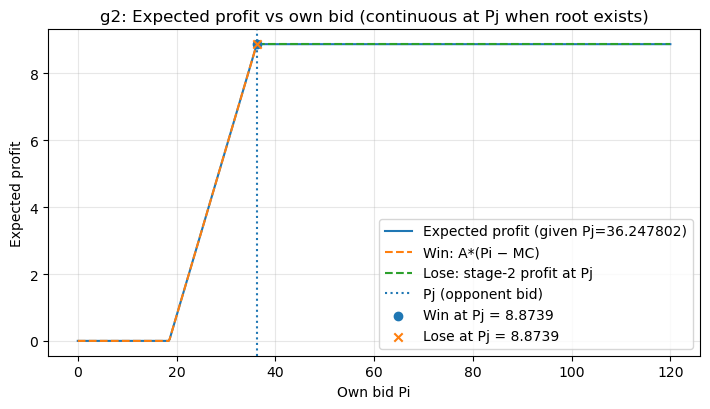

In [19]:
# ===============================================================
# Runner (example)
# ===============================================================
if __name__ == "__main__":
    # Symmetric primitives (tweak as needed)
    common = Common(alpha=0.0225, vb=3.95, MCb=22.0, A=0.5, v0=-0.4, tau=0.5)
    g1 = Gen(name="g1", vg=2.45, MCg=18.5)
    g2 = Gen(name="g2", vg=2.45, MCg=18.5)

    # One consistent set of bounds (no below-MC pricing)
    PB = (common.MCb, 200.0)
    PG = (g1.MCg, 200.0)  # = g2.MCg in symmetry

    # Find equilibrium by monotone search with jump check
    eq = equilibrium_by_monotone_search(common, g1, g2,
                                        pb_bounds=PB, pg_bounds=PG,
                                        upper=100.0, init=30.0, step=5.0, tol=1e-6)

    print("============ NVBP equilibrium (jump-aware) ============")
    for k in ["mode","reason","winner","loser","Pp_star","Pb_star","Pg_star",
              "profit_winner_tranche","profit_brand_retail","profit_loser_retail",
              "residual_mass","binds"]:
        print(f"{k:>26}: {eq[k]}")
    print("-------------------------------------------------------")

    # If there is a root (true indifference), plot expected profit vs own bid (for the loser)
    if "root" in eq["mode"]:
        me_name = "g2" if eq["winner"]=="g1" else "g1"
        plot_expected_profit_vs_own_bid(common, g1, g2,
                                        me_name=me_name,
                                        Pj_fixed=eq["Pp_star"],
                                        Pi_min=0.0, Pi_max=120.0, Pi_points=601,
                                        pb_bounds=PB, pg_bounds=PG)
    else:
        print("No indifference root (guard/jump case) — skipping plot.")